In [ ]:
import os
import csv
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import tensorflow.keras.backend as K

import math

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from DNA_Encoding import DNA_Encoding
import r2v_functions_mod as r2v

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
expName = "allModels_piRNA_generate"
outPath = "Generated"
foldName = "folds.pickle"

kmer_word2vec = 6

modelNames = ["DLNN_3", "DLNN_5", "DLNN_CORENup", "Dense_{}mer_word2vec".format(kmer_word2vec), "GlobalEmbed_RandomForest"]

epochs = 200
batch_size = 64
shuffle = False
seed = 42

dataset_path = "piRNA"
dataset_filename = "piRNA_layer1.csv"

obj_DNA_Encoding = DNA_Encoding

In [ ]:
##################################################################################
##### define custom one hot encoding, contains code from repository
##################################################################################

def one_hot_encode(sequence):
    
    seq_encoded = np.zeros((len(sequence),4))
    dict_nuc = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T":3
    }
    i = 0
    
    for single_character in sequence:
        if(single_character.upper() in dict_nuc.keys()):
            seq_encoded[i][dict_nuc[single_character.upper()]] = 1
            i = i+1
        else:
            return []
    
    return seq_encoded

def padded_one_hot_encode(sequence, max_len):
    
    cur_seq_len = len(sequence)
    ohe_seq = one_hot_encode(sequence)
    
    if cur_seq_len<max_len:
        add_seq_inst_count = max_len - cur_seq_len
        ohe_seq = np.concatenate((ohe_seq, np.zeros((add_seq_inst_count, ohe_seq.shape[1]))))
    
    return ohe_seq

def generator_of_sequences(seq_list, id_list):
        id_n = 0
        id_l = 0
        for string_seq, id_01 in zip(seq_list, id_list):
            if id_01 == 0:
                id_l = id_l + 1
                push_id = "linker_sequence_{}".format(id_l)
            elif id_01 == 1:
                id_n = id_n + 1
                push_id = "nucleosomal_sequence_{}".format(id_n)
            yield SeqRecord(Seq(string_seq), id=push_id)

In [ ]:
##################################################################################
##### Function to generate the NN with dense FC layers only
##################################################################################

def DenseNN(input_shape=(64), learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None, 
            dense_decode_units = 64, beta = 0.001):
    
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = input_shape))
    
    model.add(tf.keras.layers.Dense(dense_decode_units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [ ]:
##################################################################################
##### Function to customize the DLNN network architecture with parameters
##################################################################################

def Conv_LSTM_DLNN(input_shape=(150,4), conv_filters_per_layer = 50, kernel_length = 5, lstm_decode_units = 50, 
                   learn_rate = 0.0003, prob = 0.5, loss = 'binary_crossentropy', metrics = None, max_pool_width = 2, 
                   max_pool_stride = 2, dense_decode_units = 150):
    
    beta = 0.001
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv1D(conv_filters_per_layer, kernel_length, input_shape = input_shape, 
                                     kernel_regularizer=tf.keras.regularizers.l2(beta), padding="same"))
    
    model.add(tf.keras.layers.MaxPool1D(pool_size = max_pool_width, strides = max_pool_stride))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                                   kernel_regularizer = tf.keras.regularizers.l2(beta), dropout = 0.1))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras .layers.Flatten())

    model.add(tf.keras.layers.Dense(dense_decode_units, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='relu'))

    model.add(tf.keras.layers.Dropout(prob))

    model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='sigmoid'))
    
    #[tf.keras.metrics.binary_accuracy, metrics.precision, metrics.recall, metrics.f1score])
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [ ]:
##################################################################################
##### Function to customize the DLNN CORENup network architecture with parameters
##################################################################################

def DLNN_CORENup(input_shape = (150,4),
                 conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 50, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 370, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None, beta = 0.001):
    
    input1 = tf.keras.layers.Input(shape=input_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1, input_shape = input_shape, 
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              dropout=0.1)(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## LSTM Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)

    ## Fully connected Layers

    y = tf.keras.layers.Concatenate(1)([x2,x3])
    
    y1 = tf.keras.layers.Dense(dense_decode_units, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'relu')(y)
    
    y1 = tf.keras.layers.Dropout(prob)(y1)
    
    y1 = tf.keras.layers.Dense(1, kernel_regularizer = tf.keras.regularizers.l2(beta), activation = 'sigmoid')(y1)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=[input1], outputs=y1)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr=learn_rate), loss = loss)

    return model

In [ ]:
##################################################################################
##### Function to generate the NN with dense FC layers only
##################################################################################

def DenseNN(input_shape=(64), learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None, 
            dense_decode_units = 64):
    
    beta = 0.001
    
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = input_shape))
    
    model.add(tf.keras.layers.Dense(dense_decode_units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [ ]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [ ]:
##################################################################################
##### For each input file, train model and generate metric outputs
##################################################################################

org_ACGU_data_list = []
org_ACGT_data_list = []
zero_padded_ohe_ACGT_data_list = []
max_len = 0

##################################################################################
##### read the current file
##################################################################################

with open(os.path.join(dataset_path, dataset_filename), newline='\n') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if len(row[0]) > max_len:
            max_len = len(row[0])
        org_ACGU_data_list.append(row)

##################################################################################
##### pre process data as required by the models
##################################################################################

## converting U to T and removing all numeric characters
for row in org_ACGU_data_list: 
    org_ACGT_data_list.append([''.join([i for i in row[0].replace("U", "T") if not i.isdigit()]), row[1]])

##################################################################################
##### Generate Folds from dataset, and store to file
##################################################################################

labels = np.array([int(row[1]) for row in org_ACGT_data_list])
features = np.array([row[0] for row in org_ACGT_data_list])

## Generate the k-fold dataset
folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

print("Max length:", max_len)

In [ ]:
##################################################################################
##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

# fold counter
i = 0

## Working only with the ACGT data - folds were created after conversion to ACGT
for fold in folds:
    
    ##################################################################################
    ##### Create training and testing datasets using padded one hot encoding
    ##################################################################################
    
    fold_Xtrain_paddedOHE = np.array([padded_one_hot_encode(row, max_len) for row in fold["X_train"]])
    fold_Xtest_paddedOHE = np.array([padded_one_hot_encode(row, max_len) for row in fold["X_test"]])
    
    ##################################################################################
    ##### Create training and testing datasets using Global DNA Encoding
    ##################################################################################
    
    fold_Xtrain_paddedOHE_GlobalDNAenc = np.array([DNA_Encoding.GlobalEncoding(self = obj_DNA_Encoding, seq = row) 
                                                   for row in fold["X_train"]])
    fold_Xtest_paddedOHE_GlobalDNAenc = np.array([DNA_Encoding.GlobalEncoding(self = obj_DNA_Encoding, seq = row) 
                                                   for row in fold["X_test"]])
    
    ##################################################################################
    ##### Create training and testing datasets using word2vec
    ##################################################################################
    
    word2vec_model_extension = "6_64_3_5_5_0.0001_10"

    path_reads_train = os.path.join(dataset_path, dataset_filename.split(".")[0]+"_fold{}_train.fas".format(i))
    path_reads_test = os.path.join(dataset_path, dataset_filename.split(".")[0]+"_fold{}_test.fas".format(i))
    path_model = os.path.join(dataset_path, dataset_filename.split(".")[0]+"_"+word2vec_model_extension+"_model.pkl")
    path_totalkmers = os.path.join(dataset_path, dataset_filename.split(".")[0]+"_{}_totalkmers.pkl".format(kmer_word2vec))

    id_List = fold["y_train"]
    seq_List = fold["X_train"]
    output_handle = open(path_reads_train, "w")
    SeqIO.write(generator_of_sequences(seq_List, id_List), output_handle, "fasta")
    output_handle.close()

    id_List = fold["y_test"]
    seq_List = fold["X_test"]
    output_handle = open(path_reads_test, "w")
    SeqIO.write(generator_of_sequences(seq_List, id_List), output_handle, "fasta")
    output_handle.close()

    nr = bool(int(1))
    a = 1e-05
    v = 1000
    k = kmer_word2vec
    r2v.embed_reads(path_sample = path_reads_train, path_totalkmers = path_totalkmers, path_model = path_model, path_out = dataset_path, normread=nr, k=k, a=a, verbose=True, v=v)
    r2v.embed_reads(path_sample = path_reads_test, path_totalkmers = path_totalkmers, path_model = path_model, path_out = dataset_path, normread=nr, k=k, a=a, verbose=True, v=v)
    
    train_word2vec_reads = "".join(path_reads_train.split(".")[0:len(path_reads_train.split("."))-1])+"_"+'_'.join(path_model.split('\\')[-1].split('_')[1:-1])+'_'+str(a)+"_remb.csv.gz"
    test_word2vec_reads = "".join(path_reads_test.split(".")[0:len(path_reads_test.split("."))-1])+"_"+'_'.join(path_model.split('\\')[-1].split('_')[1:-1])+'_'+str(a)+"_remb.csv.gz"
    
    fold_train_word2vec_df = pd.read_csv(train_word2vec_reads, compression='gzip', header=0)
    fold_test_word2vec_df = pd.read_csv(test_word2vec_reads, compression='gzip', header=0)

    fold_train_nucleosomal_feature_list = fold_train_word2vec_df[fold_train_word2vec_df['Unnamed: 0'].str.contains("nucleosomal")].drop('Unnamed: 0',1).values.tolist()
    fold_train_linker_feature_list = fold_train_word2vec_df[fold_train_word2vec_df['Unnamed: 0'].str.contains("linker")].drop('Unnamed: 0',1).values.tolist()
    fold_test_nucleosomal_feature_list = fold_test_word2vec_df[fold_test_word2vec_df['Unnamed: 0'].str.contains("nucleosomal")].drop('Unnamed: 0',1).values.tolist()
    fold_test_linker_feature_list = fold_test_word2vec_df[fold_test_word2vec_df['Unnamed: 0'].str.contains("linker")].drop('Unnamed: 0',1).values.tolist()
    
    fold_train_word2vec_labels = np.concatenate((np.ones((len(fold_train_nucleosomal_feature_list), 1), dtype=np.float32), np.zeros((len(fold_train_linker_feature_list), 1), dtype=np.float32)), axis=0)
    fold_train_word2vec_features = np.concatenate((fold_train_nucleosomal_feature_list, fold_train_linker_feature_list), 0)
    fold_test_word2vec_labels = np.concatenate((np.ones((len(fold_test_nucleosomal_feature_list), 1), dtype=np.float32), np.zeros((len(fold_test_linker_feature_list), 1), dtype=np.float32)), axis=0)
    fold_test_word2vec_features = np.concatenate((fold_test_nucleosomal_feature_list, fold_test_linker_feature_list), 0)
    
    ##################################################################################
    ##### Train all different models using the 
    ##################################################################################
    
    for modelName in modelNames:
        
        modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models", modelName)
        if(not os.path.isdir(modelPath)):
            os.makedirs(modelPath)
        
        ##################################################################################
        ##### DLNN convolution-LSTM network
        ##################################################################################
        
        if modelName == "DLNN_3" or modelName == "DLNN_5":
            train_features = fold_Xtrain_paddedOHE
            test_features = fold_Xtest_paddedOHE
            train_labels = fold["y_train"]
            test_labels = fold["y_test"]
            
            kernel_length = int(modelName[-1])
            
            input_shape = fold_Xtrain_paddedOHE[0].shape
            
            ## Generate model using function
            model = Conv_LSTM_DLNN(input_shape = input_shape, conv_filters_per_layer = 50, kernel_length = kernel_length,
                                   lstm_decode_units = 50, learn_rate = 0.0003, prob = 0.5, loss='binary_crossentropy',
                                   metrics=None)
            
            ## Define the model callbacks for early stopping and saving the model. Then train model
            modelCallbacks = [
                tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                   monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                   save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                 mode = 'auto', baseline = None, restore_best_weights = False)
            ]
            model.fit(x = train_features, y = train_labels, batch_size = batch_size, epochs = epochs, 
                      callbacks = modelCallbacks, validation_data = (test_features, test_labels))
        
        ##################################################################################
        ##### CORENup DLNN convolution-LSTM network
        ##################################################################################
        
        elif modelName == "DLNN_CORENup":
            train_features = fold_Xtrain_paddedOHE
            test_features = fold_Xtest_paddedOHE
            train_labels = fold["y_train"]
            test_labels = fold["y_test"]
            
            input_shape = fold_Xtrain_paddedOHE[0].shape
            
            ## Generate model using function
            model = DLNN_CORENup(input_shape = input_shape)
            
            ## Define the model callbacks for early stopping and saving the model. Then train model
            modelCallbacks = [
                tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                   monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                   save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                 mode = 'auto', baseline = None, restore_best_weights = False)
            ]
            model.fit(x = train_features, y = train_labels, batch_size = batch_size, epochs = epochs, 
                      callbacks = modelCallbacks, validation_data = (test_features, test_labels))
        
        ##################################################################################
        ##### word2vec embedding with A fully connected NN layer
        ##################################################################################
        
        elif modelName == "Dense_{}mer_word2vec".format(kmer_word2vec):
            train_features = fold_train_word2vec_features
            test_features = fold_test_word2vec_features
            train_labels = fold_train_word2vec_labels
            test_labels = fold_test_word2vec_labels
            
            input_shape = (fold_test_word2vec_features[0].shape[0])
            
            ## Generate model using function
            model = DenseNN(input_shape = input_shape)
            
            ## Define the model callbacks for early stopping and saving the model. Then train model
            modelCallbacks = [
                tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                   monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                   save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                 mode = 'auto', baseline = None, restore_best_weights = False)
            ]
            model.fit(x = train_features, y = train_labels, batch_size = batch_size, epochs = epochs, verbose = 0, 
                      callbacks = modelCallbacks, validation_data = (test_features, test_labels))
        
        ##################################################################################
        ##### Global DNA Encoding with Random Forest
        ##################################################################################
            
        elif modelName == "GlobalEmbed_RandomForest":
            train_features = fold_Xtrain_paddedOHE_GlobalDNAenc
            test_features = fold_Xtest_paddedOHE_GlobalDNAenc
            train_labels = fold["y_train"].reshape(fold["y_train"].shape[0])
            test_labels = fold["y_test"].reshape(fold["y_test"].shape[0])
            
            model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True, criterion = "gini")

            model.fit(X = fold_Xtrain_paddedOHE_GlobalDNAenc, 
                      y = fold["y_train"].reshape(fold["y_train"].shape[0]))
            
            pickle.dump(model, open(os.path.join(modelPath, "{}_bestModel-fold{}.pkl".format(modelName, i)), 'wb'))
        
        ##################################################################################
        ##### Generate metrics on Train/test data per folds and add to Evaluations DF
        ##################################################################################
        
        # train_features
        # test_features
        # train_labels
        # test_labels
        
        ##################################################################################
        ##### Prediction and metrics for TRAIN dataset
        ##################################################################################

        y_pred = model.predict(train_features)
        label_pred = pred2label(y_pred)
        
        acc = accuracy_score(train_labels, label_pred)
        prec = precision_score(train_labels,label_pred)

        conf = confusion_matrix(train_labels, label_pred)
        if(conf[0][0]+conf[1][0]):
            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
        else:
            sens = 0.0
        if(conf[1][1]+conf[0][1]):
            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
        else:
            spec = 0.0
        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
        else:
            mcc= 0.0
        fpr, tpr, thresholds = roc_curve(train_labels, y_pred)
        auc = roc_auc_score(train_labels, y_pred)
        
        evaluations["Model"].append(modelName)
        evaluations["Fold"].append(i)
        evaluations["Train_Test"].append("Train")
        evaluations["Accuracy"].append(acc)
        evaluations["Precision"].append(prec)
        evaluations["TPR"].append(tpr)
        evaluations["FPR"].append(fpr)
        evaluations["TPR_FPR_Thresholds"].append(thresholds)
        evaluations["AUC"].append(auc)
        evaluations["Sensitivity"].append(sens)
        evaluations["Specificity"].append(spec)
        evaluations["MCC"].append(mcc)

        ##################################################################################
        ##### Prediction and metrics for TEST dataset
        ##################################################################################

        y_pred = model.predict(test_features)
        label_pred = pred2label(y_pred)
        
        acc = accuracy_score(test_labels, label_pred)
        prec = precision_score(test_labels,label_pred)

        conf = confusion_matrix(test_labels, label_pred)
        if(conf[0][0]+conf[1][0]):
            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
        else:
            sens = 0.0
        if(conf[1][1]+conf[0][1]):
            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
        else:
            spec = 0.0
        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
        else:
            mcc= 0.0
        fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
        auc = roc_auc_score(test_labels, y_pred)
        
        evaluations["Model"].append(modelName)
        evaluations["Fold"].append(i)
        evaluations["Train_Test"].append("Test")
        evaluations["Accuracy"].append(acc)
        evaluations["Precision"].append(prec)
        evaluations["TPR"].append(tpr)
        evaluations["FPR"].append(fpr)
        evaluations["TPR_FPR_Thresholds"].append(thresholds)
        evaluations["AUC"].append(auc)
        evaluations["Sensitivity"].append(sens)
        evaluations["Specificity"].append(spec)
        evaluations["MCC"].append(mcc)
    
    i = i+1
    del model
    tf.keras.backend.clear_session()
    
################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, "all")), "wb"))


In [ ]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

In [ ]:
evaluations_df

## Visualization of Evaluation

In [ ]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd
import math


In [ ]:
##################################################################################
##### Parameters used only in this section
##################################################################################

n_fold = 10
expName = "allModels_piRNA_generate"
outPath = "Generated"
kmer_word2vec = 6

modelNames = ["DLNN_3", "DLNN_5", "DLNN_CORENup", "Dense_{}mer_word2vec".format(kmer_word2vec), "GlobalEmbed_RandomForest"]


In [4]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, "all")), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [5]:
evaluations_df

,Model,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,DLNN_3,0,Train,0.883575,0.864483,"[0.0, 0.0007836990595611285, 0.273510971786833...","[0.0, 0.0, 0.0, 0.000784313725490196, 0.000784...","[1.9949371, 0.99493706, 0.94518834, 0.9449717,...",0.952408,0.904801,0.864483,0.768206
1,DLNN_3,0,Test,0.859155,0.800000,"[0.0, 0.007042253521126761, 0.4295774647887324...","[0.0, 0.0, 0.0, 0.007042253521126761, 0.007042...","[1.9974413, 0.9974413, 0.9562576, 0.95620745, ...",0.963202,0.947368,0.800000,0.732695
2,DLNN_5,0,Train,0.889063,0.864270,"[0.0, 0.0007836990595611285, 0.287617554858934...","[0.0, 0.0, 0.0, 0.000784313725490196, 0.000784...","[1.9966415, 0.9966415, 0.96070135, 0.96040165,...",0.956865,0.917508,0.864270,0.779937
3,DLNN_5,0,Test,0.845070,0.788235,"[0.0, 0.007042253521126761, 0.3450704225352112...","[0.0, 0.0, 0.0, 0.007042253521126761, 0.007042...","[1.9980617, 0.9980617, 0.97565526, 0.9737838, ...",0.959730,0.929825,0.788235,0.703962
4,DLNN_CORENup,0,Train,0.923559,0.904869,"[0.0, 0.0007836990595611285, 0.268025078369905...","[0.0, 0.0, 0.0, 0.000784313725490196, 0.000784...","[1.9926932, 0.9926932, 0.9612205, 0.9612015, 0...",0.976330,0.944079,0.904869,0.848024
...,...,...,...,...,...,...,...,...,...,...,...,...
95,DLNN_CORENup,9,Test,0.829787,0.872000,"[0.0, 0.0070921985815602835, 0.113475177304964...","[0.0, 0.0, 0.0, 0.0070921985815602835, 0.00709...","[1.9913423, 0.99134237, 0.9557005, 0.95422095,...",0.911674,0.796178,0.872000,0.663862
96,Dense_6mer_word2vec,9,Train,0.499804,0.000000,"[0.0, 0.0, 0.0, 0.0007830853563038371, 0.00078...","[0.0, 0.0007836990595611285, 0.005485893416927...","[1.4998891, 0.49988917, 0.4998879, 0.49988785,...",0.552720,0.499804,0.000000,0.000000
97,Dense_6mer_word2vec,9,Test,0.500000,0.000000,"[0.0, 0.0, 0.0, 0.0070921985815602835, 0.00709...","[0.0, 0.0070921985815602835, 0.028368794326241...","[1.499889, 0.49988905, 0.49988744, 0.49988726,...",0.465268,0.500000,0.000000,0.000000
98,GlobalEmbed_RandomForest,9,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000


In [7]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

all_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(1), ['Train'])]
all_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(1), ['Test'])]

In [8]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [10]:
metric_to_plot = "Accuracy"

In [22]:
model_list = list(np.unique(all_Train.index.get_level_values(0)))
model_list

['DLNN_3',
 'DLNN_5',
 'DLNN_CORENup',
 'Dense_6mer_word2vec',
 'GlobalEmbed_RandomForest']

In [23]:
# Filter_df  = DLNN_Train[DLNN_Train.index.isin(a)]
all_Train[all_Train.index.get_level_values('Model').isin(model_list)]

,,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Model,Train_Test,,,,,,
DLNN_3,Train,0.883597,0.861665,0.953684,0.910139,0.861665,0.769479
DLNN_5,Train,0.890417,0.875164,0.957069,0.907623,0.875164,0.781803
DLNN_CORENup,Train,0.921026,0.906858,0.976350,0.937780,0.906858,0.843335
Dense_6mer_word2vec,Train,0.499980,0.200078,0.525921,0.299902,0.200078,0.000000
GlobalEmbed_RandomForest,Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


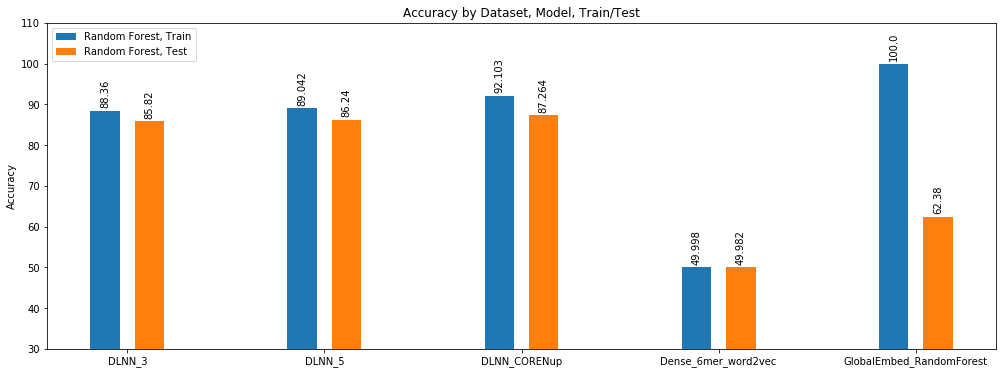

In [26]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(all_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (1.5*(width/2)), round(all_Train[metric_to_plot]*100, 3), width, label='Random Forest, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(all_Test[metric_to_plot]*100, 3), width, label='Random Forest, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(all_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
# ax.set_xticklabels([a + "_" + b.split("_")[1] for a, b in zip(RF_Train.index.get_level_values(0), RF_Train.index.get_level_values(1))],
#                   rotation=30)


ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects3)

plt.show()

In [27]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(all_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (1.5*(width/2)), round(all_Train[metric_to_plot]*100, 3), width, label='Random Forest, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(all_Test[metric_to_plot]*100, 3), width, label='Random Forest, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
                max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    ax.set_xticklabels(all_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
    #                   rotation=30)
    # ax.set_xticklabels([a + "_" + b.split("_")[1] for a, b in zip(RF_Train.index.get_level_values(0), RF_Train.index.get_level_values(1))],
    #                   rotation=30)


    ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0].format("all"))))
    plt.close()
    